In [1]:
import requests
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt


In [2]:
(input_train, target_train), (input_test, target_test) = tf.keras.datasets.mnist.load_data("/Users/dominik.waibel/Desktop/VAE/mnist.npz")

In [3]:
print(np.shape(input_train))

(60000, 28, 28)


In [4]:
# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 10
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

In [5]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [6]:
# # =================
# # Encoder
# # =================

# Definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

In [8]:
# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch     = K.shape(mu)[0]
    dim       = K.int_shape(mu)[1]
    eps       = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps

In [9]:
# Use reparameterization trick to ensure correct gradient
z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

In [10]:
# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 8)    80          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 16)     1168        batch_normalization[0][0]        
____________________________________________________________________________________________

In [11]:
# =================
# Decoder
# =================

# Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

In [12]:
# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               2352      
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 16)        2320      
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 8)         1160

In [13]:
# classification output
from tensorflow.keras.layers import GlobalAveragePooling1D
num_classes = 10
d_i = Input(shape=(latent_dim, ), name='classifier_input')
c_l = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
c_l = Dense(num_classes, activation = 'sigmoid')(c_l)

In [14]:
classifier = Model(d_i, c_l, name='classifier')
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classifier_input (InputLayer [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               2352      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                7850      
Total params: 10,202
Trainable params: 10,202
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Instantiate VAE
#vae_outputs = decoder([classifier(encoder(i)), encoder(i)[2]])
vae_outputs = [classifier(encoder(i)[2]), decoder(encoder(i)[2])]
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 17208       encoder_input[0][0]              
                                                                 encoder_input[0][0]              
__________________________________________________________________________________________________
classifier (Model)              (None, 10)           10202       encoder[1][2]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    9137        encoder[2][2]                  

In [16]:
# Define loss
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), 
                                              K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)

In [17]:
# Compile VAE
from tensorflow.keras.utils import to_categorical
vae.compile(optimizer='adam', loss=['categorical_crossentropy', kl_reconstruction_loss])

# Train autoencoder
vae.fit(input_train, [to_categorical(target_train), input_train], epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 30s 630us/sample - loss: 272.6700 - classifier_loss: 1.7882 - decoder_loss: 270.8819 - val_loss: 197.2978 - val_classifier_loss: 1.2996 - val_decoder_loss: 196.0100
Epoch 2/10
48000/48000 [==============================] - 35s 729us/sample - loss: 171.2299 - classifier_loss: 1.1864 - decoder_loss: 170.0435 - val_loss: 164.9245 - val_classifier_loss: 1.0342 - val_decoder_loss: 163.8932
Epoch 3/10
48000/48000 [==============================] - 29s 610us/sample - loss: 163.9593 - classifier_loss: 1.0165 - decoder_loss: 162.9429 - val_loss: 161.1045 - val_classifier_loss: 0.9050 - val_decoder_loss: 160.1768
Epoch 4/10
48000/48000 [==============================] - 31s 639us/sample - loss: 161.4203 - classifier_loss: 0.9370 - decoder_loss: 160.4833 - val_loss: 158.8349 - val_classifier_loss: 

In [18]:
# Adapted to accomodate this VAE.
# =================
def viz_latent_space(encoder, data):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    plt.figure(figsize=(8, 10))
    plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.show()

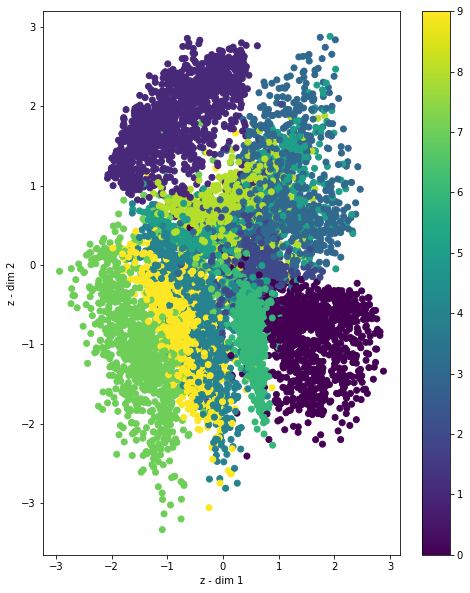

In [19]:
# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)

In [20]:
def viz_decoded(encoder, decoder, data):
    num_samples = 15
    figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
    grid_x = np.linspace(-4, 4, num_samples)
    grid_y = np.linspace(-4, 4, num_samples)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_width, img_height, num_channels)
            figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
    plt.figure(figsize=(10, 10))
    start_range = img_width // 2
    end_range = num_samples * img_width + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_width)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
    # So reshape if necessary
    fig_shape = np.shape(figure)
    if fig_shape[2] == 1:
        figure = figure.reshape((fig_shape[0], fig_shape[1]))
        # Show image
        plt.imshow(figure)
        plt.show()

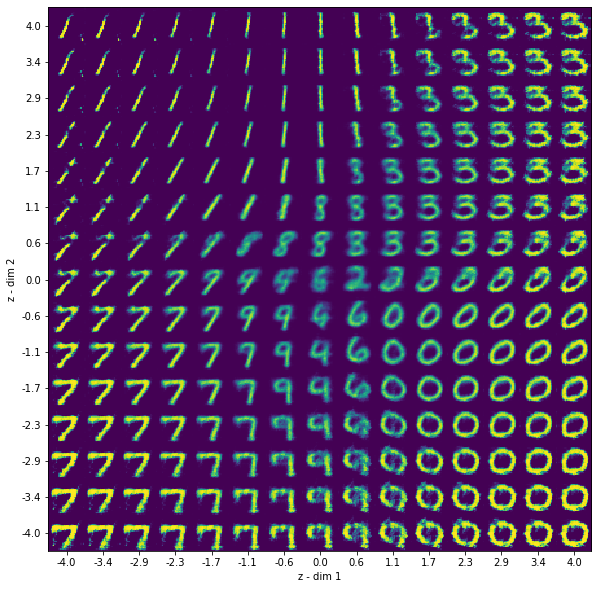

In [21]:
viz_decoded(encoder, decoder, data)

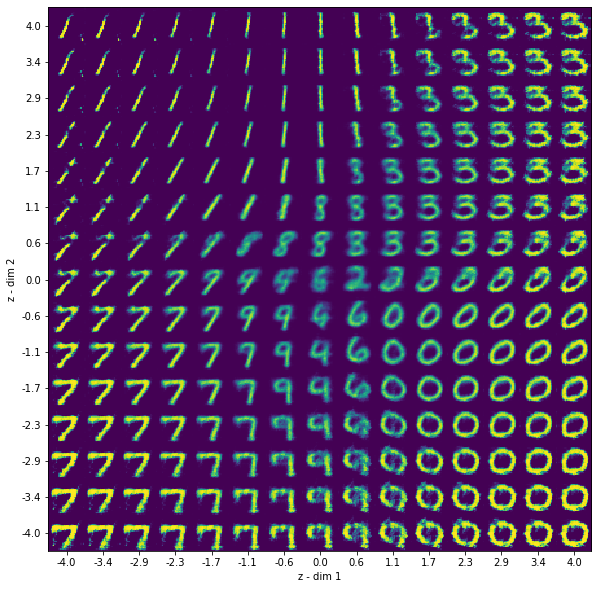

In [22]:
viz_decoded(encoder, decoder, data)

(28, 28, 1)


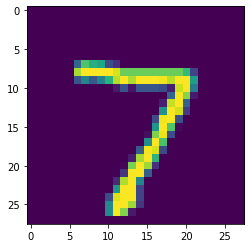

In [24]:
print(np.shape(input_test[0]))
plt.imshow(input_test[0][:,:,0])

In [25]:
mu, _, _ = encoder.predict(input_test[0][np.newaxis,...])

In [26]:
print(mu)

[[-1.7793406 -1.1363752]]


In [27]:
clas = vae.predict((input_test[0][np.newaxis,...]))

In [28]:
print(np.shape(clas[0]),np.shape(clas[1]))
print(np.argmax(clas[0]))

(1, 10) (1, 28, 28, 1)
7


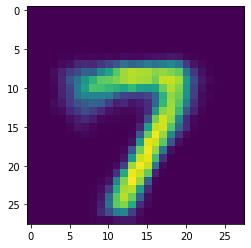

In [29]:
plt.imshow(clas[1][0,:,:,0])

In [67]:
epsilon = 0.2
import copy
from scipy.ndimage import gaussian_filter
import random
average_certainty = []
sigmas = range(0, 7)
num_latent_samples = 20
for sigma in sigmas:
    print("sigma", sigma)
    certainty = []
    for i in range(0,2000):
        test_image = copy.deepcopy(input_test[i][np.newaxis,...,np.newaxis])
        #print(np.shape(test_image))
        x = random.choice([10,14,18])
        y = random.choice([10,14,18])
        test_image[:,x-sigma:x+sigma, y-sigma:y+sigma,:] = 0
        test_image = gaussian_filter(test_image, sigma=sigma/2)

        #plt.imshow(test_image[0,:,:,0,0])
        #plt.show()
        mu, _, _ = encoder.predict(test_image[...,0])
        clas1 = classifier.predict(mu)
        clas = vae.predict((test_image[...,0]))
        predictions = []
        for rad in np.linspace(0, np.pi, num_latent_samples):
            mux = epsilon *  np.cos(rad)
            muy = epsilon *  np.sin(rad)
            predictions.append(np.argmax(classifier.predict(mu+[mux,muy])))

        #print("predicted class", np.argmax(clas1[0]))
        #print("certainty", float(predictions.count(np.argmax(clas1[0]))/6))
        #print("single predictions", predictions)
        #plt.imshow(clas[1][0,:,:,0])
        #plt.show()
        certainty.append(float(predictions.count(np.argmax(clas1[0]))/num_latent_samples))
    print(np.mean(certainty))
    average_certainty.append(np.mean(certainty))

sigma 0
0.834
sigma 1
0.831375
sigma 2
0.8067249999999999
sigma 3
0.76305
sigma 4
0.72645
sigma 5
0.681125
sigma 6
0.6770250000000001


(7,)
(7,)


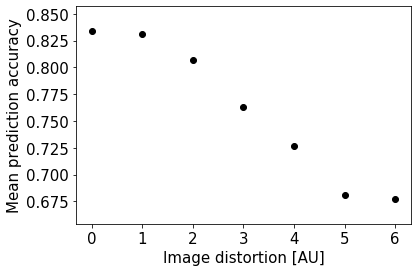

In [68]:
print(np.shape(sigmas))
print(np.shape(average_certainty))


plt.scatter(sigmas, average_certainty, color = "black")
plt.xlabel("Image distortion [AU]", size = 15)
plt.ylabel("Mean prediction accuracy", size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

In [38]:
print(np.linspace(-epsilon, epsilon, 5))

[-0.7  -0.35  0.    0.35  0.7 ]


In [39]:
print(predictions)

[3, 3, 3, 3, 3, 3]


In [40]:
np.linspace(0,10,11)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [41]:
for rad in np.linspace(0, np.pi, 10):
    x = 4 *  np.cos(rad)
    y = 4 *  np.sin(rad)
    print(x, y)

4.0 0.0
3.7587704831436337 1.3680805733026749
3.0641777724759125 2.571150438746157
2.0000000000000004 3.4641016151377544
0.6945927106677217 3.939231012048832
-0.6945927106677212 3.939231012048832
-1.9999999999999991 3.4641016151377553
-3.0641777724759116 2.571150438746158
-3.7587704831436333 1.3680805733026755
-4.0 4.898587196589413e-16
